In [1]:
version = 'v20250521'

import pandas as pd
from sklearn.model_selection import GroupKFold,cross_val_predict
from skmap.misc import find_files, GoogleSheet, ttprint
import joblib
import numpy as np
import matplotlib.pyplot as plt

prop = 'soc'
tgt = 'soc_log1p'

## read in data

In [2]:
covs = pd.read_csv(f'./metric/feature_selected_soc_{version}.txt', header=None)[0].tolist() 
model = joblib.load(f'./model/model_rf.soc_ccc_{version}.joblib')
model.n_jobs = 90

train = pd.read_parquet(f'./material/pnt_train_{version}.pq')
train = train.dropna(subset=covs+[tgt],how='any').reset_index(drop=True)
test = pd.read_parquet(f'./material/pnt_test_{version}.pq')
test = test.dropna(subset=covs+[tgt],how='any').reset_index(drop=True)

# train = train.loc[train['soc']<50]
# test = test.loc[test['soc']<50]

## generate prediction and uncertainty

In [3]:
# train the model
import copy
from trees_rf import cast_tree_rf, cast_node_rf, pad_leaf_outputs_to_array
import warnings
warnings.filterwarnings("ignore", message="X has feature names, but")

# train the model
model.fit(train[covs], train[tgt])

# variable importance
importance_df = pd.DataFrame({'feature': covs, 'importance': model.feature_importances_})
importance_df = importance_df.sort_values(by='importance', ascending=False)
importance_df.to_csv(f'./metric/feature_importance.{prop}_{version}.csv', index=False)

In [4]:
# generate prediction
y_pred = model.predict(test[covs])
y_pred = np.expm1(y_pred)
test[f'pred'] = y_pred

# cast the model
ttprint(f'start castinging')
model = cast_node_rf(model, train[covs], train[tgt])
ttprint(f'predicting training')
# generate uncertainty
node_predictions = model.predict(test[covs])
ttprint(f'start calculating')
nodes = pad_leaf_outputs_to_array(node_predictions, pad_value=np.nan)
nodes = nodes.T
nodes = np.expm1(nodes)
test['pred_std'] = np.nanstd(nodes, axis=0)
ttprint(f'finish calculating')

[10:46:55] start castinging
[10:47:08] predicting training
[10:47:33] start calculating
[10:47:35] finish calculating


In [5]:
test.to_parquet(f'./metric/point_predicted_{version}.pq')

## evaluate prediction accuracy

In [2]:
test = pd.read_parquet(f'./metric/point_predicted_{version}.pq')

y_test = test['soc']
y_pred = test['pred']

In [3]:
from model_fit import calc_metrics

rmse, mae, medae, mape, ccc, r2, bias = calc_metrics(y_pred, y_test, 'normal')
_, mae_log, _, _, ccc_log, r2_log, bias_log = calc_metrics(np.log1p(y_pred), np.log1p(y_test), 'log1p')

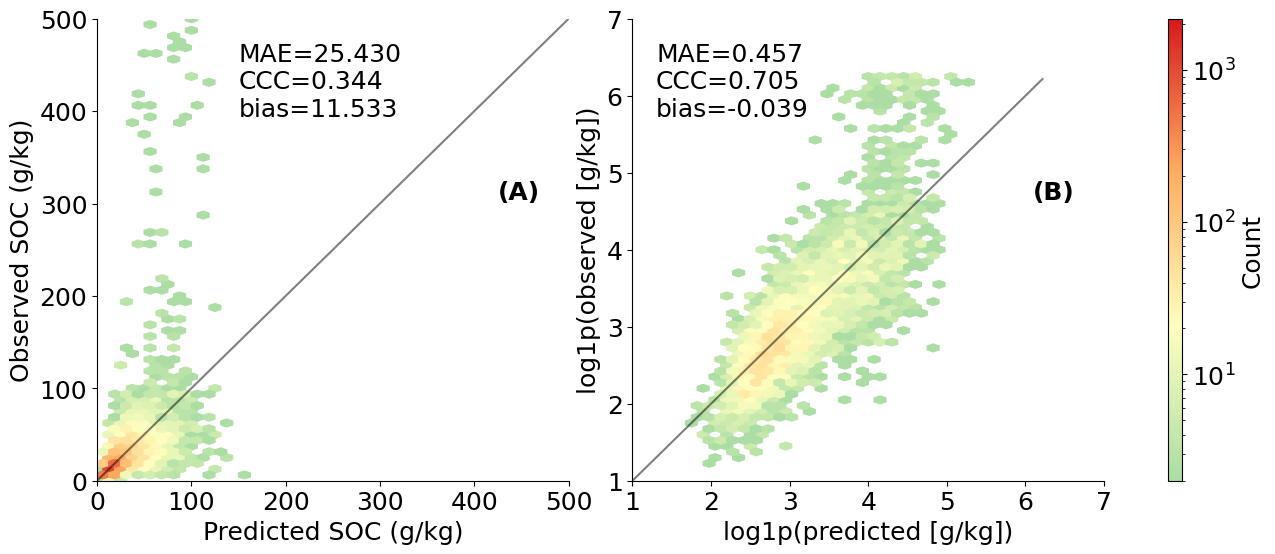

In [8]:
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from model_fit import calc_metrics
import math
import numpy as np

cet_l19_cmap = LinearSegmentedColormap.from_list(
    "CET-L19", ["#abdda4", "#ffffbf", "#fdae61", "#d7191c"]
)


vmax = 0.4 * len(y_test)

plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.03], wspace=0.2)

# Subplot 1
show_range = [0, 500]
ax1 = fig.add_subplot(gs[0])
hb1 = ax1.hexbin(y_pred, y_test, gridsize=(40, 40), cmap=cet_l19_cmap,
                 extent=[show_range[0], show_range[1], show_range[0], show_range[1]],
                 mincnt=2, vmax=vmax, bins='log')
ax1.set_xlabel('Predicted SOC (g/kg)')
ax1.set_ylabel('Observed SOC (g/kg)')
ax1.text(0.3, 0.95, 
         f'MAE={mae:.3f}\nCCC={ccc:.3f}\nbias={bias:.3f}', 
         transform=ax1.transAxes,
         verticalalignment='top',
         fontsize=18)
ax1.text(0.85, 0.65, 
         f'(A)', 
         transform=ax1.transAxes,
         verticalalignment='top',
         fontsize=18,
         fontweight='bold')
ax1.plot(show_range, show_range, "-k", alpha=0.5)
ax1.set_xlim(show_range)
ax1.set_ylim(show_range)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Subplot 2
show_range_log = [1, 7]
ax2 = fig.add_subplot(gs[1])
hb2 = ax2.hexbin(np.log1p(y_pred), np.log1p(y_test), gridsize=(40, 40), cmap=cet_l19_cmap,
                 extent=[show_range_log[0], show_range_log[1], show_range_log[0], show_range_log[1]],
                 mincnt=2, vmax=vmax, bins='log')
ax2.set_ylabel(r"log1p(observed [g/kg])")
ax2.set_xlabel(r"log1p(predicted [g/kg])")
# ax2.text(
#     0.05, 0.05,
#     r"log$_e$(1 + x)   [g kg$^{-1}$]",
#     transform=ax2.transAxes,
#     fontsize=14,
#     va='bottom',
#     ha='left'
# )

ax2.text(0.05, 0.95, 
         f'MAE={mae_log:.3f}\nCCC={ccc_log:.3f}\nbias={bias_log:.3f}', 
         transform=ax2.transAxes,
         verticalalignment='top',
         fontsize=18)
ax2.text(0.85, 0.65, 
         f'(B)', 
         transform=ax2.transAxes,
         verticalalignment='top',
         fontsize=18,
         fontweight='bold')
ax2.plot(np.log1p(show_range), np.log1p(show_range), "-k", alpha=0.5)
ax2.set_xlim(show_range_log)
ax2.set_ylim(show_range_log)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Colorbar
cbar_ax = fig.add_subplot(gs[2])
# cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
cb = fig.colorbar(hb2, cax=cbar_ax)
cb.set_label('Count')
# fig.text(0.04, 0.5,  r'$\it{c}$-model', va='center', ha='center', rotation='vertical', fontsize=20, fontweight='bold')

plt.savefig(f'./figure/plot_mdl.{prop}_evaluation.{prop}_pred.pdf', bbox_inches='tight')
plt.show()



## PI estimation evaluation

In [7]:
# calculate quantile predictions
quantiles = [0.005, 0.025, 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.495, 0.5 , 0.505, 0.55,
             0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 0.975, 0.995]
y_q = np.nanpercentile(nodes, [q * 100 for q in quantiles], axis=0)

# PIW 90% for test
test['piw_90'] = y_q[-3,:]-y_q[2,:]

# calculate QCP
def calc_qcp(predictions, true_values, quantile):
    return np.mean(true_values <= predictions)

qcp = []
for ii in range(len(quantiles)):
    qcp.append(calc_qcp(y_q[ii,:], test['soc'], quantiles[ii]))

In [8]:
# calculate PICP, PIW
def calc_picp(lower_bounds, upper_bounds, true_values):
    within_bounds = np.sum((true_values >= lower_bounds) & (true_values <= upper_bounds))
    picp = within_bounds / len(true_values)
    return picp

pi = []
picp = []
piw_m = []
piw_med = []
for ii in range(12):
    jj = len(quantiles)-1-ii
    pi.append(round(1-quantiles[ii]*2,2))
    picp.append(calc_picp(y_q[ii,:], y_q[jj,:], test['soc']))
    piw_m.append(np.mean(y_q[jj,:]-y_q[ii,:]))
    piw_med.append(np.median(y_q[jj,:]-y_q[ii,:]))

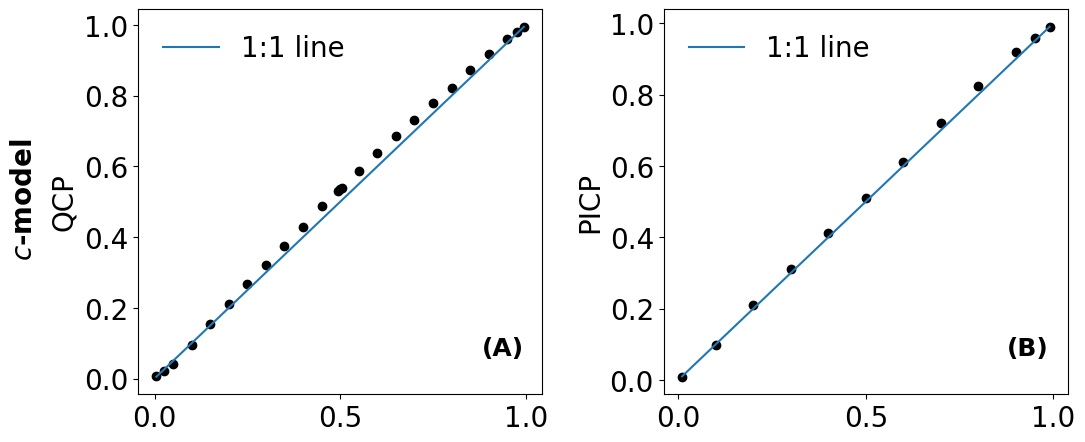

In [49]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# Plot 1: Target quantiles vs. realized quantiles
axs[0].plot(quantiles, quantiles, label='1:1 line')
axs[0].scatter(quantiles, qcp, color='black')
axs[0].set_xlabel('', fontsize=20) # Target quantiles
axs[0].set_ylabel('QCP', fontsize=20)
axs[0].legend(fontsize=20, frameon=False)  # Make legend background transparent
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].text(0.85, 0.15, 
         f'(A)', 
         transform=axs[0].transAxes,
         verticalalignment='top',
         fontsize=18,
         fontweight='bold')

# Plot 2: PI vs. PICP
# ymin, ymax = axs[1].get_ylim()
# axs[1].plot([0.95, 0.95], [0,1], 
#             color='orange', linestyle='--', linewidth=2, label='Target PI 95%:\nPICP 93%')
# axs[1].axvline(x=0.95, color='orange', linestyle='--', linewidth=2, label=f'Target PI 95%:\nPICP {picp[1]*100:.0f}%')  # Use axvline to draw a vertical line across the entire plot
axs[1].plot(pi, pi, label='1:1 line')
axs[1].scatter(pi, picp, color='black')
axs[1].set_xlabel('', fontsize=20) # PI
axs[1].set_ylabel('PICP', fontsize=20)
axs[1].legend(fontsize=20, frameon=False)  # Make legend background transparent
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].text(0.85, 0.15, 
         f'(B)', 
         transform=axs[1].transAxes,
         verticalalignment='top',
         fontsize=18,
         fontweight='bold')

# Adjust layout to prevent overlapping and add space between the panels
plt.subplots_adjust(wspace=0.3)  # Increase the space between the two plots
fig.text(0.03, 0.5,  r'$\it{c}$-model', va='center', ha='center', rotation='vertical', fontsize=20, fontweight='bold')
plt.savefig(f'./figure/plot_mdl.{prop}_evaluation.{prop}_uncertainty.svg', bbox_inches='tight')

plt.show()

## snr analysis

In [2]:
test = pd.read_parquet(f'./metric/point_predicted_{version}.pq')

In [3]:
# rename ndvi and ndwi
name_map = {'ndvi_glad.landast.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127':'ndvi',
            'ndwi.gao_glad.landsat.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231218':'ndwi'}

test = test.rename(columns = name_map)
            
for col in ['ndvi','ndwi']:
    test[col] = (test[col]-125)/125
    
# rename certain land cover names
test.loc[test['lc_survey']=='bareland', 'lc_survey'] = 'Bareland'
test.loc[test['lc_survey']=='wetland', 'lc_survey'] = 'Wetland'
test.loc[test['lc_survey']=='cropland', 'lc_survey'] = 'Cropland'
test.loc[test['lc_survey']=='woodland', 'lc_survey'] = 'Woodland'
test.loc[test['lc_survey']=='shrubland', 'lc_survey'] = 'Shrubland'
test.loc[test['lc_survey']=='grassland', 'lc_survey'] = 'Grassland'
test.loc[test['lc_survey']=='artificial land', 'lc_survey'] = 'Aritificial-land'

# calculate snr, error and abs_error for each pnt
test['snr'] = test['pred']/test['pred_std']
test['error'] = test['pred'] - test['soc']
test['abs_error'] = test['error'].abs()

# calucalte stats for each lc 
col = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']

des_pred = test.groupby(['lc_survey'])['soc'].describe()
des_pred['lc'] = des_pred.index
new_col = ['soc_'+ii for ii in col]
map_col = dict(zip(col,new_col))
des_pred = des_pred.rename(columns = map_col)

des_std = test.groupby(['lc_survey'])['pred_std'].describe()
new_col = ['std_'+ii for ii in col]
map_col = dict(zip(col,new_col))
des_std = des_std.rename(columns = map_col)

des_snr = test.groupby(['lc_survey'])['snr'].describe()
new_col = ['snr_'+ii for ii in col]
map_col = dict(zip(col,new_col))
des_snr = des_snr.rename(columns = map_col)

des = des_pred.merge(des_std, on = ['count'])
des = des.merge(des_snr, on = ['count'])
des.index = des['lc']
des = des.drop(columns=['lc'])


In [4]:
k = []
for ii in des.columns:
    if '_min' in ii:
        k.append(ii)
        
    if '_max' in ii:
        k.append(ii)
        
des = des.drop(columns=k)

# only keep land covers with enough data points
lcl = des.loc[des['count']>10].index.tolist()
des.loc[des['count']>10]

,count,soc_mean,soc_std,soc_25%,soc_50%,soc_75%,std_mean,std_std,std_25%,std_50%,std_75%,snr_mean,snr_std,snr_25%,snr_50%,snr_75%
lc,,,,,,,,,,,,,,,,
Bareland,133.0,20.850376,48.589858,6.4,10.9,18.1,17.797173,30.438738,7.306396,8.866386,11.914576,1.285224,0.462886,1.024698,1.230522,1.472907
Cropland,2369.0,17.121570,21.547797,9.7,13.6,19.2,14.252595,17.437956,7.187173,8.959278,13.086508,1.501038,0.565420,1.074976,1.467579,1.927730
Grassland,1197.0,36.719215,51.748903,14.9,25.0,40.0,38.557926,34.862347,12.931083,26.342855,50.935848,1.059296,0.491048,0.622726,1.038588,1.416280
Shrubland,101.0,46.408911,72.563112,14.4,30.1,49.3,44.900818,42.060524,20.316393,29.806215,47.577805,0.983075,0.401686,0.730326,1.012410,1.266274
Woodland,1589.0,88.725865,121.777893,22.5,42.5,81.6,97.590935,56.502544,41.062469,105.235939,145.089935,0.714652,0.338347,0.462091,0.631999,0.885166


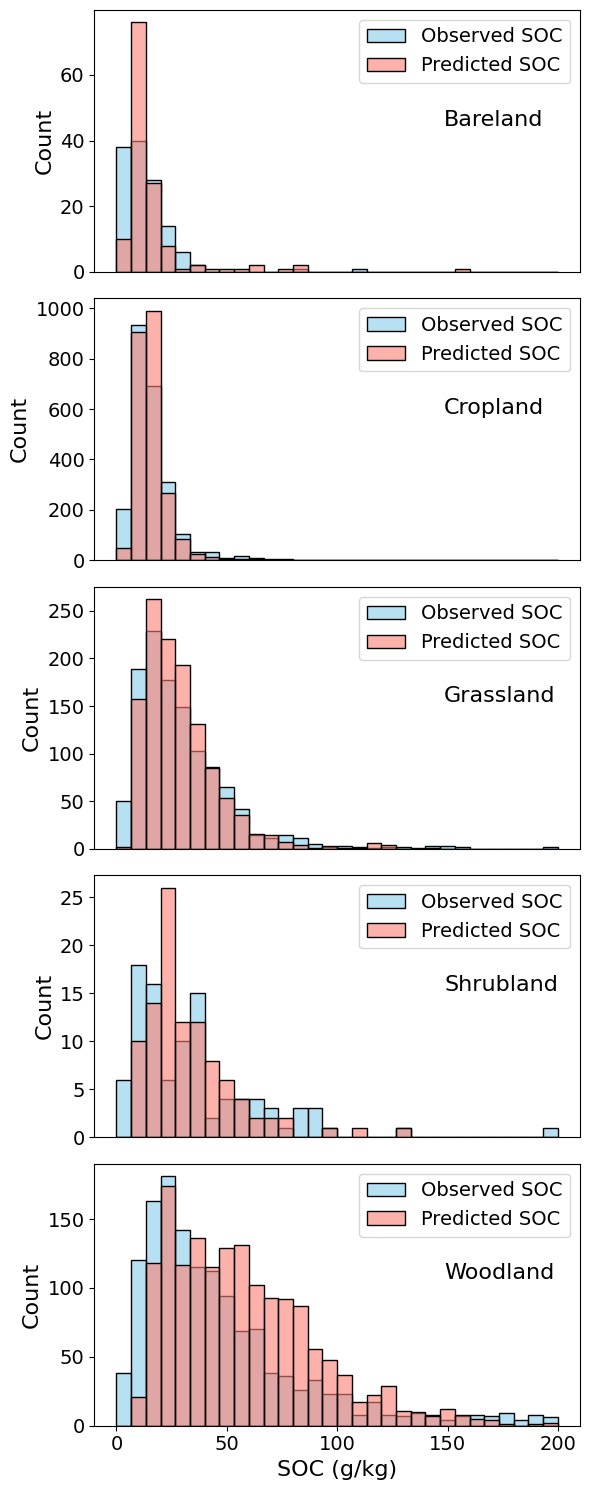

In [5]:
import seaborn as sns

fig, axes = plt.subplots(len(lcl), 1, figsize=(6, 3 * len(lcl)), squeeze=False)

for i, lc in enumerate(lcl):
    ax = axes[i, 0] 
    
    subset = test[test['lc_survey'] == lc]
    bin_edges = np.linspace(0, 200, 31) 
    
    sns.histplot(subset['soc'], label='Observed SOC', color='skyblue', alpha=0.6, stat='count', bins=bin_edges, ax=ax)
    sns.histplot(subset['pred'], label='Predicted SOC', color='salmon', alpha=0.6, stat='count', bins=bin_edges, ax=ax)
    # ax.set_title(f'{lc} - {len(subset)} points', fontsize=13)
    ax.set_xlabel('')
    if i!=4:
        ax.set_xticks([])
    ax.text(0.72, 0.62, f'{lc}', transform=ax.transAxes,
            fontsize=16, verticalalignment='top', horizontalalignment='left')
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_ylabel('Count', fontsize=16)

    if i == 0:
        ax.legend(loc='center right')
    elif i==4:
        ax.set_xlabel('SOC (g/kg)', fontsize=16)
    else:
        ax.legend().remove()  # remove legends for lower plots if you want cleaner look
    # ax.grid(True)
    ax.legend(fontsize=14)

plt.tight_layout()
# plt.savefig(f'./figure/plot_pnt_hist_obs.pred.svg', bbox_inches='tight')
plt.show()


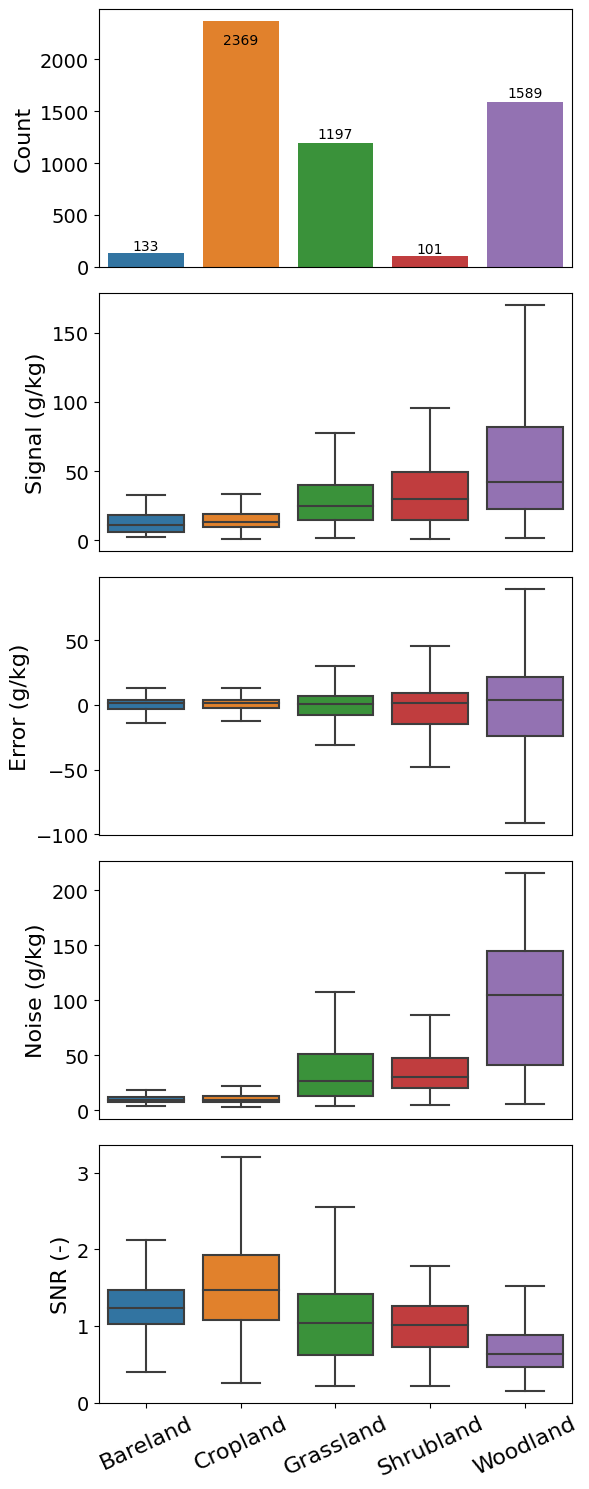

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define custom x-axis order
lc_order = ['Bareland', 'Cropland', 'Grassland', 'Shrubland', 'Woodland']#,'Aritificial-land','Wetland'
boxplot_vars = ['soc', 'error', 'pred_std', 'snr']
boxplot_labels = ['Signal (g/kg)','Error (g/kg)','Noise (g/kg)','SNR (-)']
n_rows = len(boxplot_vars) + 1  # +1 for bar plot

# Create subplots
fig, axes = plt.subplots(n_rows, 1, figsize=(6, 3* n_rows), squeeze=False)

# --- Bar plot (top plot) ---
ax = axes[0, 0]
group_counts = test['lc_survey'].value_counts().reindex(lc_order)
barplot = sns.barplot(x=group_counts.index, y=group_counts.values, order=lc_order, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Count', fontsize=16)
ax.tick_params(axis='x', bottom=False, labelbottom=False)  # hide x-ticks and labels
ax.tick_params(axis='y', which='major', labelsize=14)

for i, bar in enumerate(barplot.patches):
    height = bar.get_height()
    if height > 2000:
        height_loc = 2100
    else:
        height_loc = height
    ax.text(bar.get_x() + bar.get_width()/2, height_loc + 0.01 * height_loc,  # slight vertical offset
            f'{int(height)}', ha='center', va='bottom', fontsize=10)


# --- Boxplots ---
for i, var in enumerate(boxplot_vars):
    ax = axes[i+1, 0]
    sns.boxplot(data=test, x='lc_survey', y=var, order=lc_order, ax=ax, showfliers=False)
    ax.set_ylabel(boxplot_labels[i], fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)

    # Only show x-axis labels and ticks on the **last (bottom) plot**
    if i != len(boxplot_vars) - 1:
        ax.set_xlabel('')
        ax.tick_params(axis='x', bottom=False, labelbottom=False)
    else:
        ax.set_xlabel('', fontsize=16)
        ax.tick_params(axis='x', rotation=25, labelsize=16)

plt.tight_layout()
plt.savefig(f'./figure/plot_pnt_bar.box_metrics.svg', bbox_inches='tight')
plt.show()
